In [38]:
# Generic imports
#%%
import os
import random
import shutil
import progress.bar
from   datetime import datetime
from scipy.stats import qmc
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, ifft

import shapes
import meshes
import importlib

importlib.reload(shapes)
importlib.reload(meshes)

from shapes import *
from meshes import *

### ************************************************
### Generate full dataset
# Parameters
def generate_samples(numero_samples,n_base, latin_gen_bool, bit_im = False):
    n_sampling_pts = 20
    mesh_domain    = False
    plot_pts       = True
    show_quadrants = True
    n_shapes       = numero_samples
    time           = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')
    dataset_dir    = 'dataset_'+time+'/'
    mesh_dir       = dataset_dir+'meshes/'
    img_dir        = dataset_dir+'images/'
    det_img_dir    = dataset_dir+'det_images/'
    bit_img_dir    = dataset_dir+'bit_images/'
    save_det_plot = False

    filename       = 'shape'
    magnify        = 1.0
    max_radius = (2)**0.5
    xmin           =-2.0
    xmax           = 2.0
    ymin           =-2.0
    ymax           = 2.0
    n_tri_max      = 5000
    n_pts = n_base

    ### generate latin hypercube points in the defined space
    equ_dim_lim = 1.5

    if latin_gen_bool != False:
        latin_gen = qmc.LatinHypercube(d=n_pts*2)
        latin_gen = latin_gen.random(n=n_shapes)
        latin_gen = equ_dim_lim * latin_gen

        latin_gend2 = qmc.LatinHypercube(d=n_pts*2)
        latin_gend2 = latin_gend2.random(n=n_shapes)
        latin_gend2 = latin_gend2 * 0.9
        radius_tot = latin_gend2.reshape(-1,n_shapes,n_pts)
        edgy_tot   = latin_gend2.reshape(-1,n_shapes,n_pts)
    else:
        latin_gen = False


    # Create directories if necessary
    if not os.path.exists(mesh_dir):
        os.makedirs(mesh_dir)
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
    if not os.path.exists(det_img_dir):
        os.makedirs(det_img_dir)
    if not os.path.exists(bit_img_dir):
        os.makedirs(bit_img_dir)

    # Generate dataset
    bar = progress.bar.Bar('Generating shapes', max=n_shapes)
    df = pd.DataFrame(columns=['curve_points', 'area', 'perimeter','bitmap'])

    for i in range(0,n_shapes):
        generated = False
        while (not generated):
            if not latin_gen_bool:
                #n_pts  = random.randint(3, 7)
                radius = np.random.uniform(0.3, .9, size=n_pts)
                edgy   = np.random.uniform(0.1, .5, size=n_pts)
            else:
                radius = radius_tot[0,i,:]
                edgy   = radius_tot[1,i,:]

            shape  = Shape(filename+'_'+str(i),
                        None,
                        n_pts,
                        n_sampling_pts,
                        radius,
                        edgy,
                        save_det_plot = save_det_plot)
            
            shape.generate(magnify=1.0,
                        xmin=xmin,
                        xmax=xmax,
                        ymin=ymin,
                        ymax=ymax,
                        latin_gen = latin_gen)
            
            if save_det_plot:
                img  = filename+'_'+str(i)+"det_plot"+'.png'
                shutil.move(img,  det_img_dir)
            
            shape.generate_bitmap(bit_im=bit_im)

            if bit_im:
                img  = filename+'_'+str(i)+"bit"+'.png'
                shutil.move(img,  bit_img_dir)


            new_rows = [{'curve_points': shape.curve_pts, 'area': shape.area, 'perimeter': shape.curve_length, "bitmap": shape.bitmap}]
            df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
            generated = True
            #meshed, n_tri = shape.mesh()
            """
            if (True):
                shape.generate_image(plot_pts=plot_pts,
                                    max_radius = max_radius,
                                    xmin=xmin,
                                    xmax=xmax,
                                    ymin=ymin,
                                    ymax=ymax,
                                    show_quadrants=True)
                img  = filename+'_'+str(i)+'.png'
                mesh = filename+'_'+str(i)+'.mesh'
                shutil.move(img,  img_dir)
                #shutil.move(mesh, mesh_dir)
                generated = True
            """
        bar.next()
    bit = df["bitmap"]
    curve = df["area"]
    # End bar
    bar.finish()
    return bit,df


In [39]:
def generate_data_indicators(latin_gen = False, number_of_samples = 100, seeds = 4):
    list_mse_mean = np.array([])
    list_mse_var = np.array([])
    seeds = seeds
    bit, df1 = generate_samples(number_of_samples,seeds, latin_gen)
    stack1 = np.stack(bit.values)
    mean1_img = np.mean(stack1, axis=0)
    mse1 = np.mean((stack1 - mean1_img) ** 2, axis=(1, 2))
    mean1 = np.mean(mse1)
    var1 = np.var(mse1)
    list_mse_mean = np.append(list_mse_mean, mean1)
    list_mse_var = np.append(list_mse_var, var1)

    points = df1["curve_points"]
    df1["angles"] = None
    df1["angles"] = df1["angles"].astype(object)
    df1["spectra"] = None
    df1["spectra"] = df1["spectra"].astype(object)
    limit = 20
    for index,row in df1.iterrows():
        points = row["curve_points"]
        angles = np.arctan2(points[:, 1], points[:, 0])
        df1.at[index, "angles"] = angles
        og_data = np.linalg.norm(points, axis = 1)

        fs1 = angles.shape[0]/(2*np.pi)
        samples1 = og_data
        fft1 = fft(og_data)
        freqs1 = fftfreq(len(samples1), 1/fs1)
        df1.at[index,"spectra"] = fft1[:limit]/points.shape[0]

    spectra = df1["spectra"]
    spectra = np.stack(spectra.values)
    var_energy = spectra.var(axis = 0)
    mean_energy = abs(spectra).mean(axis = 0)

    var_angle = np.angle(spectra).var(axis = 0)
    mean_angle = np.angle(spectra).mean(axis = 0)

    return var_energy, mean_energy, var_angle, mean_angle, df1
    

In [40]:
import time

score_array = []
df1_arrays = []
plt.figure()  # rOnly call this once
for seed_points in range (4,7):
    var_energy_array = []
    mean_energy_array = []
    var_angle_array = []
    mean_angle_array = []
    seed_points = seed_points + 3
    for elements in range(10):
        var_energy, mean_energy, var_angle, mean_angle,df1 = generate_data_indicators(number_of_samples = 50, seeds = seed_points)
        var_energy_array.append(var_energy[1:])
        mean_energy_array.append(mean_energy[1:])
        var_angle_array.append(var_angle)
        mean_angle_array.append(mean_angle)
        time.sleep(0.1)  # delays for 2 seconds
        df1_arrays.append(df1)

    total_score = np.array(var_energy_array)**0.5 * np.array(mean_energy_array)
    total_score = total_score.sum(axis = 1)
    score_array.append(total_score)
    

/var/folders/9p/c80ms72x1zq5xk4ppbknqzlm0000gn/T/ipykernel_41290/1209503134.py:121: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
/var/folders/9p/c80ms72x1zq5xk4ppbknqzlm0000gn/T/ipykernel_41290/1209503134.py:121: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
/var/folders/9p/c80ms72x1zq5xk4ppbknqzlm0000gn/T/ipykernel_41290/1209503134.py:121: FutureWarning: The behavior 

<Figure size 640x480 with 0 Axes>

In [42]:
total_score

array([0.00979228, 0.01139586, 0.01092088, 0.01124369, 0.0114041 ,
       0.01046162, 0.01092038, 0.01140459, 0.0117063 , 0.01191292])

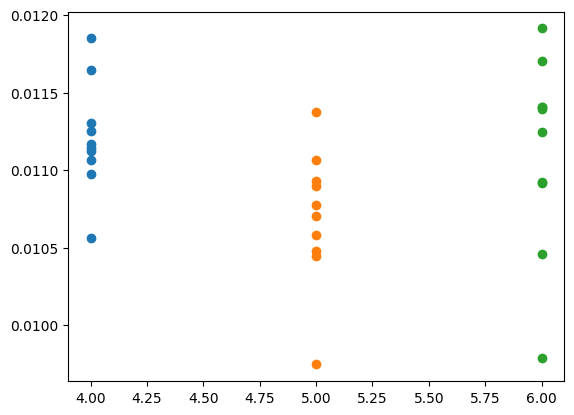

In [41]:
i = 4
for elements in score_array:
    plt.scatter(elements *0+i, elements)
    i+=1



NameError: name 'spectra' is not defined

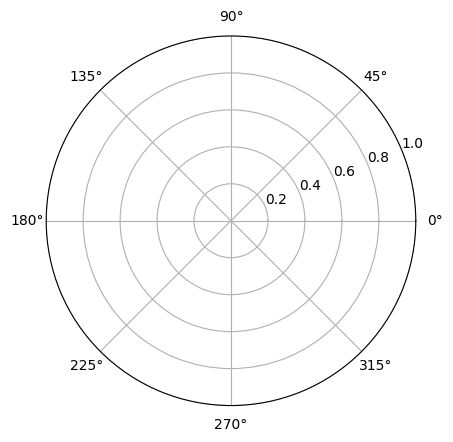

In [18]:
plt.figure()
ax = plt.subplot(111, polar=True)
colors = plt.cm.viridis(np.linspace(0, 1, spectra.shape[0]))
lols = 0
for dataframe in df1_arrays:
    spectra = dataframe["spectra"].values
    for i in range(spectra.shape[0]):
        theta = np.angle(spectra[i][1:])
        r = np.abs(spectra[i][1:])
        ax.scatter(theta, r, color=colors[i], label=f"Spectrum {i}")

        plt.title("Polar Plot of Spectra")
        plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3)

    if lols == 0:
        print("here")
        break
plt.show()


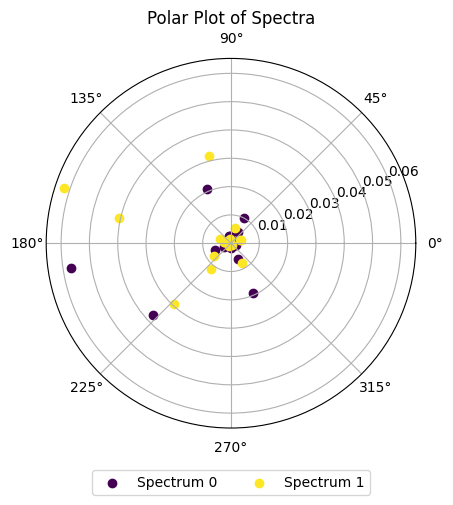

In [154]:
plt.figure()
ax = plt.subplot(111, polar=True)
colors = plt.cm.viridis(np.linspace(0, 1, spectra.shape[0]))
lols = 0
for dataframe in df1_arrays:
    spectra = dataframe["spectra"].values
    if lols == 0:
        lols += 1
        pass
    else:
        for i in range(spectra.shape[0]):
            theta = np.angle(spectra[i][1:])
            r = np.abs(spectra[i][1:])
            ax.scatter(theta, r, color=colors[i], label=f"Spectrum {i}")

            plt.title("Polar Plot of Spectra")
            plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3)


plt.show()


In [26]:
np.linspace(0,total_score.shape[0],total_score.shape[0])* 0 +seed_points

array([5., 5., 5., 5., 5.])

In [19]:
total_score = np.array(var_energy_array) * np.array(mean_energy_array)
total_score = total_score.sum(axis = 1)

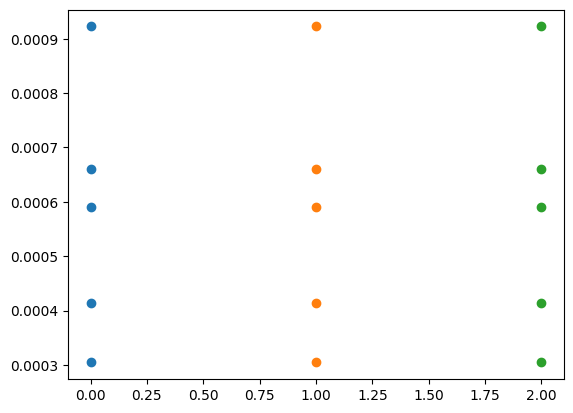

In [35]:
for i in range(3):
    plt.scatter(np.linspace(0,total_score.shape[0],total_score.shape[0])* 0 +i, total_score)


In [15]:
mean_angle_array

[array([ 0.        ,  0.31163223, -0.23507393, -0.27445296,  0.18626726,
        -0.13486283, -0.44547135, -0.26102454,  0.18908574, -0.16140798,
        -0.17658139, -0.20203952,  0.13588489, -0.14204717,  0.10030549,
         0.03621556,  0.02996414,  0.18924836, -0.07037912, -0.05553657]),
 array([ 0.        ,  0.18119726, -0.29658953, -0.08247048,  0.26120806,
        -0.03708521, -0.04776792, -0.12125031, -0.14384568,  0.04956041,
        -0.12766416,  0.13491033, -0.15396049,  0.02250305, -0.06949914,
         0.05461082, -0.06022675, -0.1598552 , -0.11027009, -0.10905761]),
 array([ 0.        ,  0.00484013, -0.51158686,  0.0087217 ,  0.16441672,
         0.10183838, -0.19527877,  0.05278073, -0.06440995,  0.10296911,
         0.11529769, -0.00494392, -0.16475372,  0.13963655, -0.21365567,
         0.02290464, -0.01274738,  0.20424335, -0.20599026,  0.19918452]),
 array([ 0.        , -0.03445467, -0.18397901, -0.0628723 ,  0.24502046,
         0.0027151 , -0.28174852,  0.04709712